In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = '1'


In [2]:
import sys

sys.path.append('/home/caio/dev/')

In [3]:


from torch import nn
from torch.utils.data import DataLoader, random_split
import torch
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt



from bprMf.utils import train, generate_bpr_dataset
from evaluation import Evaluate
from bprMf.bpr_mf import  bprMFWithClickDebiasing, bprMf

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
interactions = pd.read_csv('movielens_1m_ratings.csv')[["user", "item", "rating"]]
interactions["relevant"] = interactions["rating"].apply(lambda r: int(r >= 4))
zero_based_indexing = {v: K for K, v in enumerate(interactions["item"].unique())}
interactions["item"] = interactions["item"].map(zero_based_indexing)

In [6]:
interactions.groupby("user").agg({"item": list})

,item
user,
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,"[53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 6..."
3,"[175, 176, 58, 177, 178, 179, 180, 64, 181, 18..."
4,"[63, 64, 208, 209, 210, 44, 48, 113, 124, 127,..."
5,"[218, 219, 220, 221, 222, 223, 224, 225, 59, 2..."
...,...
6036,"[1892, 2470, 1326, 558, 240, 33, 97, 450, 876,..."
6037,"[97, 256, 1118, 1120, 1492, 128, 2072, 1253, 6..."
6038,"[1615, 153, 1509, 1033, 206, 535, 1528, 1340, ..."


## Developing a MF model based using BPR opt


Now we'll generalize the previous implementation using implicit feedback data and applying BPR (Bayesian personalized ranking) loss function, so that the model is capable of building personalzied rankings for users

### Step 1 : adapt training data for BPR


BPR expects implicit feedback data and relative ordering in the training dataset

In [7]:

zero_based_indexing = {v: K for K, v in enumerate(interactions["item"].unique())}
interactions["item"] = interactions["item"].map(zero_based_indexing)

#bpr_df = generate_bpr_dataset(interactions)

### Temp: Creating bpr dataset with vector operations

### Step 2: Create a MF model using BPR loss function

In [8]:
n_users = interactions.user.max() + 1
n_items = interactions.item.max() + 1

In [9]:
n_users, n_items

(np.int64(6041), np.int64(3706))

In [10]:



model = bprMf(
                num_users=n_users,
                num_items=n_items,
                factors=50,
                reg_lambda=5e-4,
                n_epochs=10).to(device)

### Training the model

In [11]:
%%time
trained_model, train_losses = train(model, interactions, train_ratio=0.7)

CPU times: user 2min 2s, sys: 796 ms, total: 2min 3s
Wall time: 2min


In [12]:
train_losses

[0.32725025155881243,
 0.28832039061269,
 0.2881838602345791,
 0.28815459895237,
 0.2881780981062994,
 0.288175852841451,
 0.2881921403409263,
 0.28819886843110926,
 0.2882490250427346,
 0.2882346935574028]

## Developing a BPR variant for click position debiasing

In [13]:
interactions["click"] = np.random.randint(0, 20, size=len(interactions))

In [14]:
interactions

,user,item,rating,relevant,click
0,1,0,5,1,17
1,1,1,3,0,4
2,1,2,3,0,13
3,1,3,4,1,12
4,1,4,5,1,15
...,...,...,...,...,...
1000204,6040,772,1,0,1
1000205,6040,1106,5,1,2
1000206,6040,365,5,1,8
1000207,6040,152,4,1,15


In [15]:
n_users = interactions.user.max() + 1
n_items = interactions.item.max() + 1

In [16]:
model = bprMFWithClickDebiasing(
                num_users=n_users,
                num_items=n_items,
                factors=50,
                reg_lambda=1e-3,
                n_epochs=10).to(device)




In [17]:
%%time
trained_model, train_losses = train(model, interactions, train_ratio=0.7)

CPU times: user 2min 32s, sys: 787 ms, total: 2min 33s
Wall time: 2min 30s


In [18]:
train_losses

[0.7485308143304094,
 0.20155224525267906,
 0.19786997415204913,
 0.19571762935774062,
 0.19451486392407838,
 0.19383390984546733,
 0.19354862710683554,
 0.19329763252343027,
 0.19303739128087946,
 0.19301356786192525]

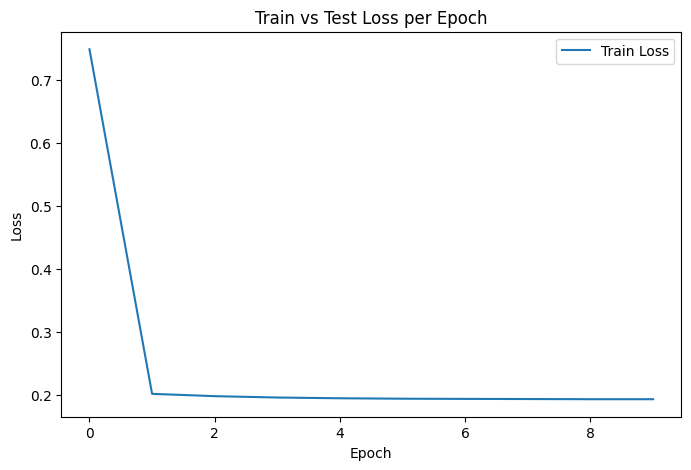

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.show()

In [35]:
test_loss = model.evaluate(dataloader_bpr_test)

In [36]:
test_loss

1.020030519841644

In [37]:
evaluator = Evaluate(model, test_data, interactions, k=20)

In [38]:
evaluator.MAP_at_k()

0.06997351358585503